Plan:
1. Generate a balanced set with a single feature and apply classification
2. Dilute this set by using a small percentage of ones.
3. Apply prediction again and see difference.
4. Apply corrections and see whether they achieve balanced results.

In [38]:
from sklearn.datasets import make_classification, make_blobs
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib notebook
from IPython.core.debugger import set_trace
import numpy as np
import pandas as pd

In [43]:
#Generate various datasets - some artificially generated, and some real-world
n_samples_artificial = 100008

dataset_artificial_balanced_1_feature = \
                            make_blobs(n_samples=n_samples_artificial, n_features=1, centers=[[-1], [1]],
                                cluster_std=[1.0, 0.5],  shuffle=False, random_state=4) 
                                       
dataset_artificial_balanced_1_feature
# dataset_artificial_balanced_1_feature = \
#                             make_classification(n_samples=n_samples_artificial, n_features=1, n_informative = 1,
#                             n_redundant=0,n_repeated=0, n_clusters_per_class=1, flip_y=0, random_state=5, 
#                             class_sep=0.5, scale=1)
# dataset_artificial_imbalanced_2_features = \
#                             make_classification(n_samples=n_samples_artificial, n_features=4, n_redundant=0,
#                             n_clusters_per_class=1, weights=[0.5], flip_y=0, random_state=4)

(array([[-0.94943829],
        [-0.50004867],
        [-1.99590893],
        ...,
        [ 1.55486124],
        [ 1.45712704],
        [ 1.27812248]]), array([0, 0, 0, ..., 1, 1, 1]))

1: mean: 0.998, std: 0.498 
 0: mean: -1.000, std: 0.997 


<IPython.core.display.Javascript object>


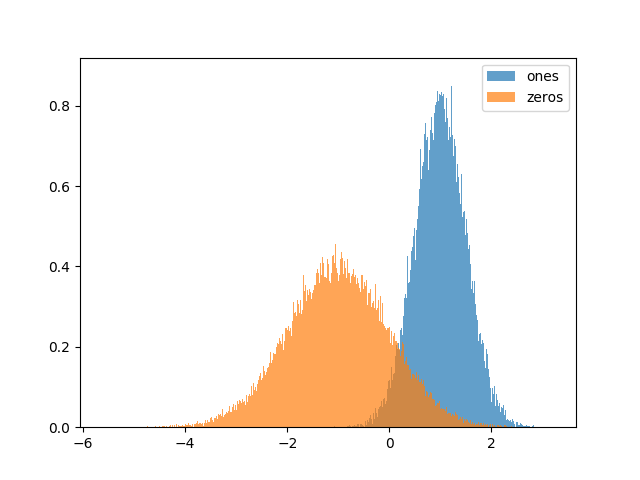

(100008, 1)

In [44]:

# Choose the set to work with
X, y = dataset_artificial_balanced_1_feature
X_ones = X[y==1].T[0]
X_zeros = X[y==0].T[0]
# set_trace()
print("1: mean: {:0.3f}, std: {:0.3f} \n 0: mean: {:0.3f}, std: {:0.3f} ".format(X_ones.mean(), X_ones.std(), X_zeros.mean(), X_zeros.std()))
fig, ax_hist = plt.subplots()
ax_hist.hist(X_ones, bins = 500, density=True, alpha = 0.7, label="ones")
ax_hist.hist(X_zeros, bins = 500, density=True, alpha = 0.7, label = "zeros")
ax_hist.legend()
X.shape

In [49]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2 )

In [50]:
clf = LogisticRegressionCV(cv=5, random_state=0).fit(X_train, y_train)

In [51]:
y_hat = clf.predict(X_test)
print(clf.classes_)
print(classification_report(y_hat, y_test ))

[0 1]
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      9220
           1       0.95      0.89      0.92     10782

    accuracy                           0.91     20002
   macro avg       0.91      0.92      0.91     20002
weighted avg       0.92      0.91      0.92     20002



In [52]:
print("Intercept:{}, theta_1: {}".format(clf.intercept_, clf.coef_))
print("Classification threshold: {}".format(-clf.intercept_/clf.coef_))

Intercept:[-0.39275848], theta_1: [[2.33542047]]
Classification threshold: [[0.16817463]]


In [53]:
X.T[0]

array([-0.94943829, -0.50004867, -1.99590893, ...,  1.55486124,
        1.45712704,  1.27812248])

<IPython.core.display.Javascript object>


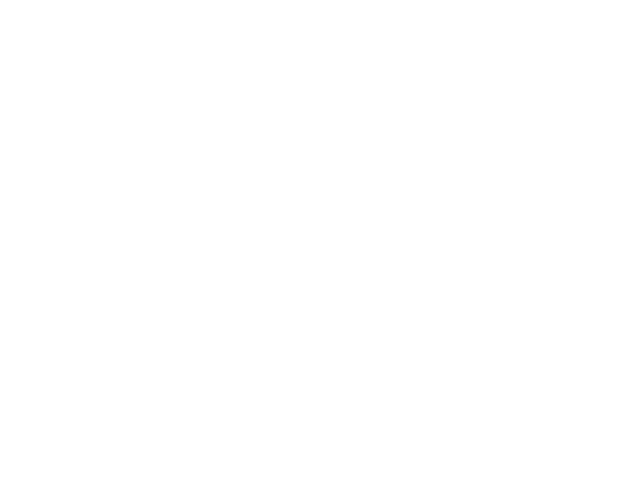

No handles with labels found to put in legend.


In [54]:
%matplotlib qt
import matplotlib.pyplot as plt
fig,ax1 = plt.subplots()
ax1.scatter(X,y)
# ax1.scatter(X_test, y_test)



test_probs = clf.predict_proba(X_test)
ax1.scatter(X_test, test_probs[:,1])
ax1.legend()
plt.show()

In [55]:
from IPython.core.debugger import set_trace
def calc_bin_prob(bn_df):
#     set_trace()
    bin_x = bn_df[0].left
    df = bn_df[1]
    prob_1 = np.nan if len(df) == 0 else df['y'].sum()/len(df) 
    return bin_x, prob_1

X_y_df = pd.DataFrame({'X':X.T[0], 'y':y})
X_y_df['x_binned'] = pd.cut(X_y_df['X'], bins=np.arange(X.min(), X.max(), 0.05))
x_binned = []
prob_one_binned = []
for bn_df in X_y_df.groupby('x_binned'):
    bin_x, prob_1 = calc_bin_prob(bn_df)
    x_binned.append(bin_x)
    prob_one_binned.append(prob_1)

ax1.plot(x_binned, prob_one_binned)

In [ ]:
sum(y==1)/len(y)

In [ ]:
y==1

<IPython.core.display.Javascript object>


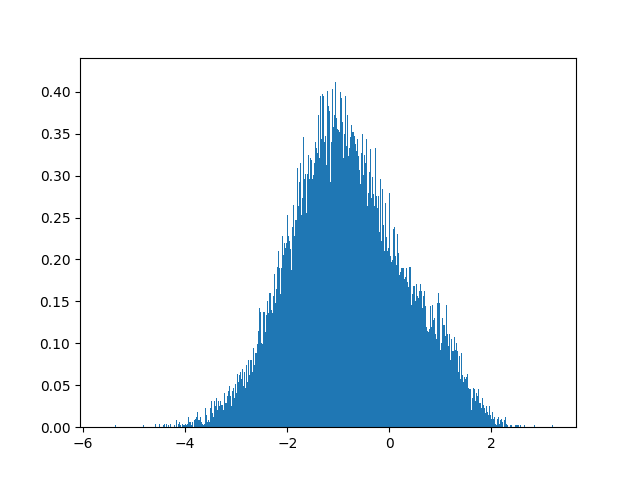

In [67]:
#Dilute the 1's class
import random 
diluting_factor = 0.1
ones_y_indices = y==1
num_ones = sum(ones_y_indices)
diluted_ys_indices =  random.sample(range(num_ones), int(num_ones*diluting_factor))
diluted_ys = y[ones_y_indices][diluted_ys_indices]
diluted_X_zeros = X[y==0]
diluted_X_ones = X[ones_y_indices][diluted_ys_indices]
diluted_X = np.concatenate([diluted_X_zeros, diluted_X_ones])
diluted_y = np.concatenate([ y[y==0], diluted_ys])
plt.scatter(diluted_X, diluted_y)
plt.figure()
plt.hist(diluted_X, bins=1000, density=True)
plt.show()

In [72]:
#Predict on diluted data
X_train_D, X_test_D, y_train_D, y_test_D = train_test_split(diluted_X, diluted_y, test_size = 0.2) 
print(sum(y_train_D))
print(sum(y_test_D))
diluted_clf = LogisticRegressionCV(cv=5, random_state=0).fit(X_train_D, y_train_D)
y_hat_D = diluted_clf.predict(X_test_D)
print(classification_report(y_hat_D, y_test_D ))
probs_D = diluted_clf.predict_proba(X_test_D)
print("Theta0_D: {}, theta1_D: {}".format(diluted_clf.intercept_, diluted_clf.coef_))
ax1.scatter(X_test_D, probs_D[:,1])
print(confusion_matrix(y_test_D, y_hat_D, labels=[1,0]))

4016
984
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     10210
           1       0.53      0.66      0.59       791

    accuracy                           0.93     11001
   macro avg       0.75      0.81      0.78     11001
weighted avg       0.94      0.93      0.94     11001

Theta0_D: [-2.82177408], theta1_D: [[2.97661369]]
[[ 526  458]
 [ 265 9752]]


In [73]:
#Prior correction
tau = sum(y)/len(y)
y_bar =  sum(diluted_y)/len(diluted_y)
print(y_bar)
corrected_intercept = diluted_clf.intercept_ - np.log( (1-tau)/tau*y_bar/(1-y_bar)    )
diluted_clf.intercept_ = corrected_intercept
y_hat_D_corrected = diluted_clf.predict(X_test_D)
print(classification_report(y_hat_D_corrected, y_test_D ))
probs_D_corrected = diluted_clf.predict_proba(X_test_D)
ax1.scatter(X_test_D, probs_D_corrected[:,1])
plt.show()

0.09090247981964948
              precision    recall  f1-score   support

           0       0.88      0.99      0.93      8869
           1       0.95      0.44      0.60      2132

    accuracy                           0.89     11001
   macro avg       0.92      0.72      0.77     11001
weighted avg       0.89      0.89      0.87     11001



In [61]:
print("Intercept:{}, theta_1: {}".format(diluted_clf.intercept_, diluted_clf.coef_))
print("Classification threshold: {}".format(-diluted_clf.intercept_/diluted_clf.coef_))

Intercept:[3.54512235], theta_1: [[11.09306056]]
Classification threshold: [[-0.31958019]]


In [ ]:
print(corrected_intercept)
print((1-tau)/tau*y_bar/(1-y_bar))
print(y_bar/(1-y_bar))

In [75]:
#Weighing
tau = sum(y)/len(y)
y_bar =  sum(diluted_y)/len(diluted_y)
w1 = tau/y_bar
w0 = (1-tau)/(1-y_bar)
diluted_clf_weighing = LogisticRegressionCV(cv=5, random_state=0, class_weight={0:w0, 1:w1}).fit(X_train_D, y_train_D)
y_hat_D = diluted_clf_weighing.predict(X_test_D)
print(classification_report(y_hat_D, y_test_D ))
probs_D = diluted_clf_weighing.predict_proba(X_test_D)
print("Theta0_D: {}, theta1_D: {}".format(diluted_clf_weighing.intercept_, diluted_clf_weighing.coef_))
ax1.scatter(X_test_D, probs_D[:,1])
y_hat_all_weighing = diluted_clf_weighing.predict(X_test)
print(classification_report(y_hat_all_weighing, y_test))
probs_all_weighing = diluted_clf_weighing.predict_proba(X_test)
ax1.scatter(X_test, probs_all_weighing[:,1])

              precision    recall  f1-score   support

           0       0.89      0.99      0.94      9010
           1       0.93      0.46      0.62      1991

    accuracy                           0.90     11001
   macro avg       0.91      0.73      0.78     11001
weighted avg       0.90      0.90      0.88     11001

Theta0_D: [-0.86705957], theta1_D: [[3.65609987]]
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      9501
           1       0.94      0.90      0.92     10501

    accuracy                           0.91     20002
   macro avg       0.91      0.92      0.91     20002
weighted avg       0.92      0.91      0.91     20002



In [78]:
df = pd.DataFrame({'a':[1,2,3], 'b':[4,5,6]})
df['a'] = [1,2,3,4]

ValueError: Length of values does not match length of index